In [1]:
import pickle
import itertools
import open3d as o3d
import numpy as np
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from scipy import interpolate
from scipy import ndimage

In [3]:
import sklearn
from sklearn.decomposition import PCA
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
import pathlib

In [4]:
p = pathlib.Path("curves_by/q_curves/q_e/q_1_a/128_b20_s60_lmin40_lmax_100_o15_w5.curves")
ind = "q_1_a"
paras = p.stem
img_num = paras.split("_")[0]

In [5]:
with open(p, "rb") as pickle_file:
    curve_fragment = pickle.load(pickle_file)

In [6]:
cfs = [[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]

In [29]:
with open('template_curves.pickle', 'wb') as f:
    pickle.dump(cfs, f)

In [26]:
import json
pts_dict = {}
for i in range(8):
    #pts = np.concatenate(cfs[i], axis=0)
    pts = [j.tolist() for j in cfs[i]]
    pts_dict[i] = pts
    
#json_str = json.dumps(pts_dict)
f = open('template_curves.json', 'w')
json.dump(pts_dict, f)
f.close()

In [8]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

t = 20
def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if j % t != 0:
                j+=1
                continue
            j+=1
            if frag.size < 10:
                continue
            #if i != 4:
            #    continue
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            except UnboundLocalError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            ax.plot(new[0], new[2], new[1],"-",color=c)

<IPython.core.display.Javascript object>


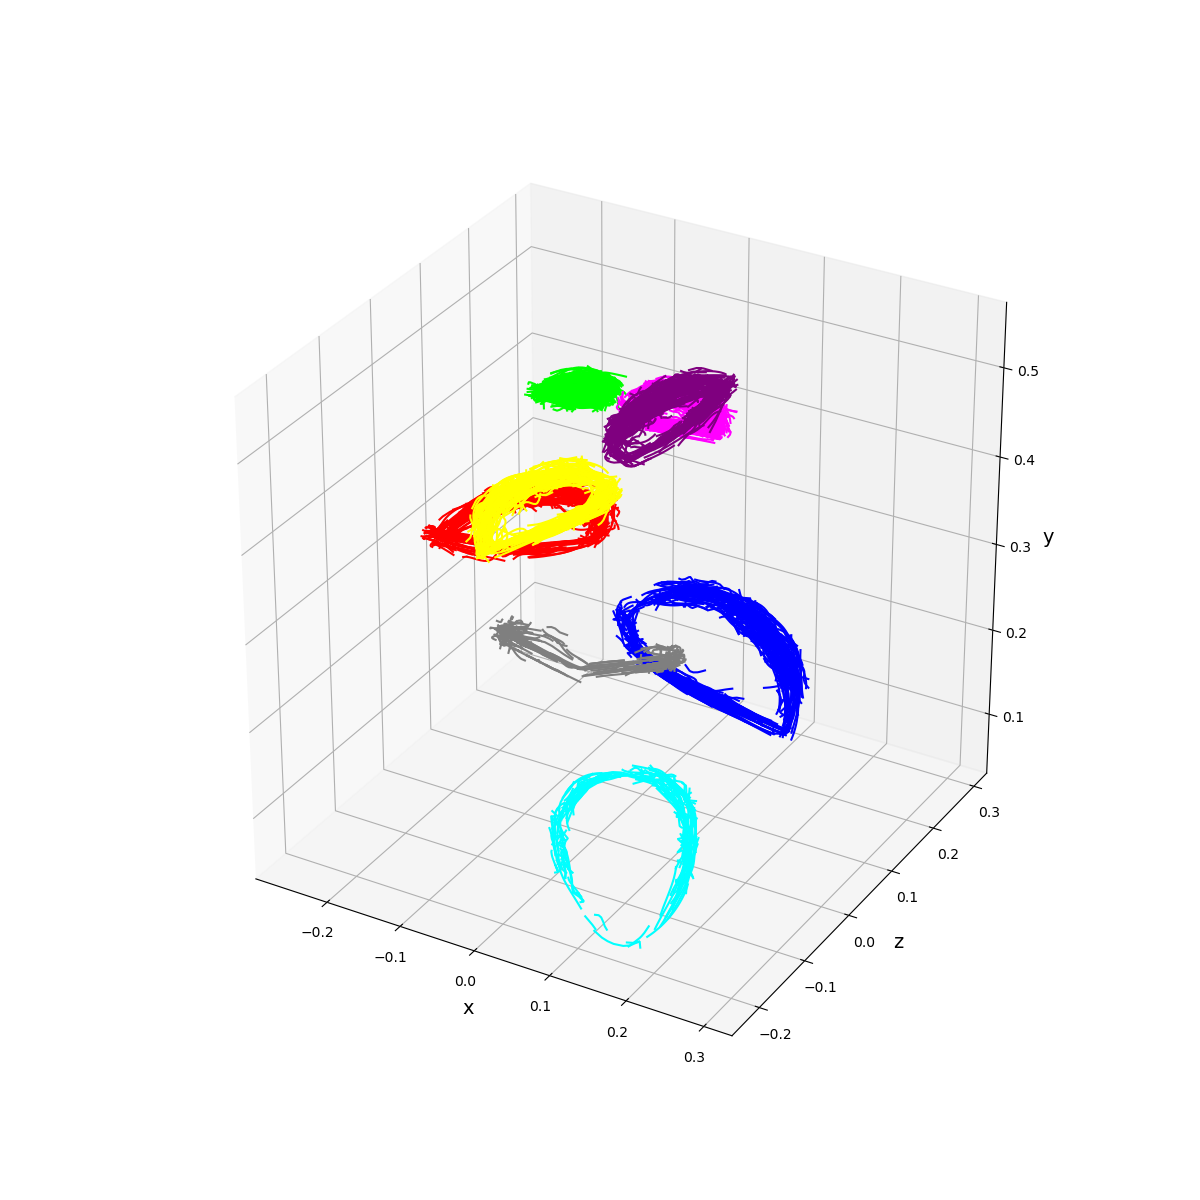

In [9]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))

plot_graph()

In [15]:
from scipy import interpolate
color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)

_cfs = []
j = 0
for i in range(len(cfs)):
    color_cfs=[]
    for frag in cfs[i]:
        if j % t != 0:
            j+=1
            continue
        j+=1
        if frag.size < 10:
            continue
        #if i != 4:
        #    continue
            
        x = frag[:,0]
        y = frag[:,1]
        z = frag[:,2]
        data = [x,y,z]
        try:
            tck, u= interpolate.splprep(data, k=3)
        except ValueError:
            pass
        except TypeError:
            pass
        except UnboundLocalError:
            pass
        new = interpolate.splev(u, tck, der=0)
        c = color_arr[i]/255
        
        color_cfs.append(np.array([new[0], new[1], new[2]]).transpose(1,0))
    _cfs.append(color_cfs)

In [16]:
def clustering(cfs_part):
    flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cfs_part)))
    pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)
    labels = np.array(pcd.cluster_dbscan(eps=0.005, min_points=10))
    unique, freq = np.unique(labels, return_counts=True)
    mode = unique[np.argmax(freq)]
    flatten_curve_frag = flatten_curve_frag[labels==mode]
    return flatten_curve_frag
    
def same_checker(ls):
    for i, num1 in enumerate(ls):
        for j, num2 in enumerate(ls):
            if i == j:
                continue
            if np.abs(num1 - num2) <0.0005:
                return num1

def sort_cluster(cluster):
    pca = PCA()
    pca.fit(cluster)
    feature = pca.transform(cluster)

    r = (feature[:, 0]**2 + feature[:, 1]**2)**(1/2)
    cos = feature[:, 0]/r
    sin = feature[:, 1]/r

    arccos = np.arccos(cos)
    arcsin = np.arcsin(sin)
    arccos_m = -arccos
    arcsin_m = -np.pi -arcsin
    arcsin_p = np.pi - arcsin
    
    feature_theta = []
    for temp_list in zip(arccos, arcsin, arccos_m, arcsin_m, arcsin_p):
        theta = same_checker(temp_list)
        feature_theta.append(theta)
    feature_theta = np.array(feature_theta)
    
    cluster_ex_nan = cluster[np.where(feature_theta != None)]
    feature_theta_ex_nan = feature_theta[np.where(feature_theta != None)]
    sorted_theta = np.sort(feature_theta_ex_nan)
    sorted_idx = np.argsort(feature_theta_ex_nan)
    sorted_cluster = cluster_ex_nan[sorted_idx]
    return sorted_cluster, sorted_theta

def outlier_removal(sorted_cluster, theta):
    x = sorted_cluster[:,0]
    y = sorted_cluster[:,2]
    z = sorted_cluster[:,1]
    data = [x,y,z]

    jump = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) 
    smooth_jump = ndimage.gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
    limit = 2*np.median(smooth_jump)    # factor 2 is arbitrary
    xn, yn, zn = x[:-1], y[:-1], z[:-1]
    theta = theta[:-1]
    xn = xn[(jump > 0) & (smooth_jump < limit)]
    yn = yn[(jump > 0) & (smooth_jump < limit)]
    zn = zn[(jump > 0) & (smooth_jump < limit)]
    theta = theta[(jump > 0) & (smooth_jump < limit)]
    data = [xn,yn,zn]
    return data, theta

def organize_data(flatten_curve_frag):
    sorted_cluster, theta = sort_cluster(flatten_curve_frag)
    data, theta = outlier_removal(sorted_cluster, theta)
    
    return data, theta

In [17]:
pcd = o3d.geometry.PointCloud()
data_list = []
theta_list = []
for i in range(len(_cfs)):
    flatten_curve_frag = np.array(list(itertools.chain.from_iterable(_cfs[i])))
    #pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)
    #labels = np.array(pcd.cluster_dbscan(eps=0.005, min_points=10))
    #unique, freq = np.unique(labels, return_counts=True)
    #mode = unique[np.argmax(freq)]
    #flatten_curve_frag = flatten_curve_frag[labels==mode]
    data, theta = organize_data(flatten_curve_frag)
    data_list.append(data)
    theta_list.append(theta)


In [18]:
# 赤，緑，青，黄，ピンク，水，灰，紫
q_1_h_list = [[0.035, 0.043, 0.035, 0.027, 0.04, 0.026, 0.02, 0.035],
             [0.03, 0.029, 0.035, 0.035, 0.035, 0.025, 0.02, 0.035],
             [0.035, 0.029, 0.035, 0.04, 0.038, 0.028, 0.025, 0.038]]

q_2_h_list = [[0.02, 0.025, 0.03, 0.02, 0.025, 0.02, 0.02, 0.03],
             [0.025, 0.032, 0.035, 0.027, 0.035, 0.02, 0.028, 0.035],
             [0.03, 0.03, 0.04, 0.035, 0.041, 0.025, 0.03, 0.041]]

q_3_h_list = [[0.04, 0.064, 0.045, 0.061, 0.077, 0.018, 0.023, 0.07],
             [0.052, 0.062, 0.039, 0.046, 0.056, 0.012, 0.023, 0.047],
             [0.05, 0.049, 0.043, 0.055, 0.057, 0.016, 0.025, 0.054]]

q_4_h_list = [[0.06, 0.04, 0.03, 0.07, 0.04, 0.06, 0.03, 0.06],
             [0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21],
             [0.10, 0.10, 0.11, 0.09, 0.1, 0.09, 0.1, 0.1]]

q_5_h_list = [[0.06, 0.04, 0.03, 0.07, 0.04, 0.06, 0.03, 0.06],
             [0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21],
             [0.13, 0.10, 0.15, 0.1, 0.13, 0.13, 0.1, 0.13]]

# 赤，緑，青，黄，ピンク，水，灰，紫
q_6_h_list = [[0.06, 0.04, 0.03, 0.07, 0.04, 0.06, 0.03, 0.06],
             [0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21],
             [0.1, 0.09, 0.14, 0.1, 0.12, 0.1, 0.08, 0.12]]

q_7_h_list = [[0.06, 0.04, 0.03, 0.07, 0.04, 0.06, 0.03, 0.06],
             [0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21],
             [0.17, 0.16, 0.14, 0.16, 0.15, 0.18, 0.08, 0.19]]

q_8_h_list = [[0.06, 0.04, 0.03, 0.07, 0.04, 0.06, 0.03, 0.06],
             [0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21],
             [0.15, 0.14, 0.14, 0.14, 0.16, 0.16, 0.09, 0.18]]

q_9_h_list = [[0.06, 0.04, 0.03, 0.07, 0.04, 0.06, 0.03, 0.06],
             [0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21],
             [0.13, 0.12, 0.1, 0.13, 0.12, 0.13, 0.07, 0.13]]

q_10_h_list = [[0.06, 0.04, 0.03, 0.07, 0.04, 0.06, 0.03, 0.06],
             [0.13, 0.12, 0.12, 0.11, 0.18, 0.14, 0.11, 0.21],
             [0.25, 0.2, 0.19, 0.19, 0.22, 0.24, 0.12, 0.23]]

In [19]:
# 赤，緑，青，黄，ピンク，水，灰，紫
q_1_n1_h_list = [[0.09, 0.11, 0.1, 0.11, 0.11, 0.078, 0.058, 0.12],
                 [0.059, 0.055, 0.059, 0.06, 0.065, 0.042, 0.034, 0.058],# 50
                 [0.095, 0.12, 0.1, 0.13, 0.12, 0.079, 0.048, 0.12]]# 70

q_2_n1_h_list = [[0.13, 0.123, 0.138, 0.095, 0.104, 0.091, 0.108, 0.133],#50
                 [0.054, 0.043, 0.05, 0.056, 0.056, 0.046, 0.055, 0.052],# 50
                 [0.098, 0.16, 0.12, 0.09, 0.12, 0.08, 0.085, 0.12]]

q_3_n1_h_list = [[0.094, 0.114, 0.089, 0.129, 0.109, 0.03, 0.042, 0.128],# 50
                 [0.137, 0.2, 0.13, 0.175, 0.14, 0.033, 0.07, 0.147],# 50
                 [0.078, 0.093, 0.072, 0.088, 0.081, 0.013, 0.035, 0.074]]# 100

In [181]:
# 赤，緑，青，黄，ピンク，水，灰，紫
q_1_n3_h_list = [[0.4, 0.465, 0.573, 0.55, 0.482, 0.45, 0.216, 1.11],# 25
                 [0.092, 0.068, 0.103, 0.120, 0.081, 0.098, 0.038, 0.170],# 20
                 [0.743, 0.838, 0.98, 0.79, 0.9, 0.54, 0.4, 1.03]]# 10

q_2_n3_h_list = [[0.5, 1.075, 0.6, 0.6, 0.6, 0.445, 0.438, 0.6],# 10
                 [0.25, 0.408, 0.27, 0.205, 0.25, 0.25, 0.25, 0.345],# 10
                 [0.140, 0.145, 0.133, 0.112, 0.216, 0.123, 0.123, 0.210]]# 10

q_3_n3_h_list = [[0.860, 1.14, 1.318, 1.498, 1.03, 0.263, 0.545, 1.63],# 10
                 [0.650, 0.650, 0.510, 0.795, 0.440, 0.100, 0.287, 1.120],# 10
                 [0.735, 0.89, 0.683, 0.985, 0.62, 0.0890, 0.260, 0.900]] # 20

In [182]:
s_curve_list = []
pcd = o3d.geometry.PointCloud()
for i in range(len(data_list)):
    tck, u = interpolate.splprep(data_list[i], u=theta_list[i], s=q_3_n3_h_list[2][i], k=3, per=1)
    new = interpolate.splev(u, tck, der=0)
    prossed_data = np.array(new)
    smooth_curve = np.stack([prossed_data[0],prossed_data[1],prossed_data[2]],axis=1)
    s_curve_list.append(smooth_curve)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][8649]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][8649]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][8649]=x[2][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][7866]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][7866]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][7866]=x[2][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack

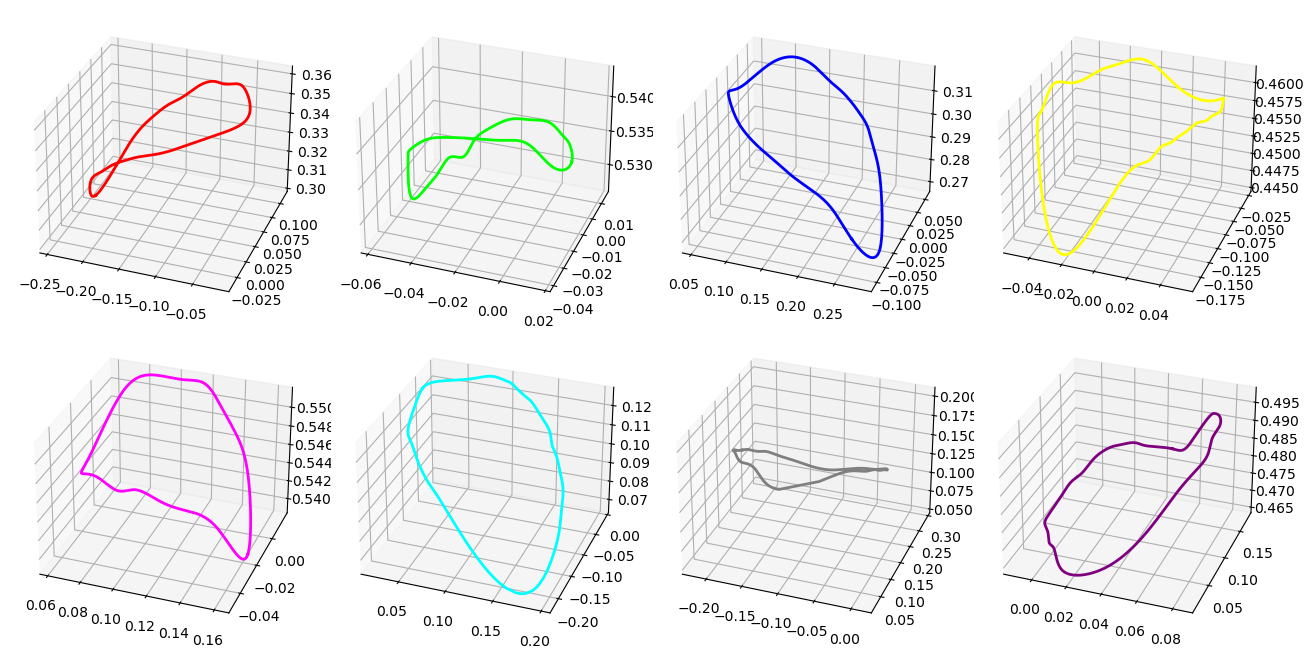

In [183]:
%matplotlib inline
fig = plt.figure(figsize = (13, 13))
fig.patch.set_alpha(0.)
# 3DAxesを追加

c_list = ["#FF0000","#00FF00","#0000FF","#FFFF00","#FF00FF","#00FFFF","#7F7F7F","#7F007F"]

ax1 = fig.add_subplot(441, projection='3d')
ax2 = fig.add_subplot(442, projection='3d')
ax3 = fig.add_subplot(443, projection='3d')
ax4 = fig.add_subplot(444, projection='3d')
ax5 = fig.add_subplot(445, projection='3d')
ax6 = fig.add_subplot(446, projection='3d')
ax7 = fig.add_subplot(447, projection='3d')
ax8 = fig.add_subplot(448, projection='3d')

ax_list = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
# 軸ラベルを設定
for i in range(8):
    x, y, z = s_curve_list[i][:,0], s_curve_list[i][:,1], s_curve_list[i][:,2]
    ax_list[i].plot(x, y, z,"-",c=c_list[i],linewidth = 2.0)
    ax_list[i].view_init(elev=30, azim=-70)

fig.tight_layout()
plt.show()

In [184]:
mesh = o3d.io.read_triangle_mesh("polygon/quan_e_a/{}.ply".format(ind))
edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)

In [185]:
def edges_to_lineset(mesh, edges, color):
    ls = o3d.geometry.LineSet()
    ls.points = mesh.vertices
    ls.lines = edges
    colors = np.empty((np.asarray(edges).shape[0], 3))
    colors[:] = color
    ls.colors = o3d.utility.Vector3dVector(colors)
    return ls

def rotation_mat(angle):
    Rx = np.array([[1,0,0],
                 [0, np.cos(angle[0]), -np.sin(angle[0])],
                 [0, np.sin(angle[0]), np.cos(angle[0])]])

    Ry = np.array([[np.cos(angle[1]), 0, np.sin(angle[1])],
                 [0,1,0],
                 [-np.sin(angle[1]), 0, np.cos(angle[1])]])

    Rz = np.array([[np.cos(angle[2]), -np.sin(angle[2]), 0],
                 [np.sin(angle[2]), np.cos(angle[2]), 0],
                 [0,0,1]])
    return Rz@Rx@Ry

In [186]:
angle = [np.pi, np.pi, 0] # pcd.rotate()
#angle = [-np.pi/2, np.pi/2, np.pi/2]
R = rotation_mat(angle)
R_mirror = np.array([[-1,0,0],
                    [0,1,0],
                    [0,0,1]])

In [187]:
geo = []

for j, l_c in enumerate(s_curve_list):
    points = l_c
    lines = [[i,i+1] for i in range(len(points)-1)]
    colors = [color_arr[j]/255 for i in range(len(lines))]
    #print(len(points),len(lines),len(colors))

    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)
    line_set.rotate(np.linalg.inv(R),(0,0,0))
    line_set.scale(10,(0,0,0))
    geo.append(line_set)

#o3d.visualization.draw_geometries(geo)
geo.append(mesh)
#geo.append(edges_to_lineset(mesh, edges, (1, 0, 0)))
o3d.visualization.draw_geometries(geo)

In [188]:
output = "curves_by/q_curves/q_e_noise_3mm/{}/s_{}".format(ind, p.name)
import pickle
with open(output,"wb") as f:
    pickle.dump(s_curve_list, f)

In [189]:
def get_pts(mesh, edges, max_point_num=10000):
    vertices = np.asarray(mesh.vertices)
    edges = np.asarray(edges)
    dist = 0
    for i in range(len(vertices[edges])):
        start = vertices[edges][i][0]
        end = vertices[edges][i][1]
        dist_part = np.sqrt(np.sum(np.square(start - end)))
        dist += dist_part
    unit_dist = dist/max_point_num
    next_start_length = 0
    next_start_partation = 0
    pts_list = []
    for i in range(len(vertices[edges])):
        start = vertices[edges][i][0]
        end = vertices[edges][i][1]
        next_st_pt = start + (end - start)*next_start_partation
        dist_part = np.sqrt(np.sum(np.square(start - end)))
        dist_nx = np.sqrt(np.sum(np.square(next_st_pt - end)))
        pts_num = int(dist_nx/unit_dist)+1
        pts = next_st_pt + np.repeat(np.arange(pts_num),3).reshape((pts_num,3)) * (end - next_st_pt)/(pts_num-1)
        end_pts = pts[-1]
        next_start_length = pts_num*unit_dist - dist_part + next_start_length
        next_start_partation = next_start_length/dist_part
        pts_list.append(pts)

    pts_array = np.concatenate(pts_list)

    return pts_array

In [190]:
with open(output, "rb") as pickle_file:
    s_curve_list = pickle.load(pickle_file)

In [191]:
rng = np.random.default_rng(123)
mesh = o3d.io.read_triangle_mesh("polygon/quan_e_a/{}.ply".format(ind))
y_emd = []
x_area = []
for i in range(np.max(np.asarray(mesh.cluster_connected_triangles()[0]))+1):
    mesh = o3d.io.read_triangle_mesh("polygon/quan_e_a/{}.ply".format(ind))
    mesh.triangles = o3d.utility.Vector3iVector(np.asarray(mesh.triangles)[np.asarray(mesh.cluster_connected_triangles()[0])==i])

    _, _, area = mesh.cluster_connected_triangles()
    edges = mesh.get_non_manifold_edges(allow_boundary_edges=False)
    com = get_pts(mesh, edges)
    emd_list = []
    for j in range(8):
        x1 = s_curve_list[j]
        x1 = x1[np.round(np.arange(500) * len(x1)/500).astype("int64")]
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(x1)
        pcd.rotate(np.linalg.inv(R),(0,0,0))
        pcd.scale(10,(0,0,0))
        x1 = np.asarray(pcd.points)
        

        x2 = com

        d = cdist(x1, x2)
        assignment = linear_sum_assignment(d)
        emd = d[assignment].sum() / x1.shape[0]
        emd_list.append(emd)
        
    emd = np.min(emd_list)
    y_emd.append(emd)
    x_area.append(area[0])

In [192]:
y_emd

[0.05492281512959451,
 0.07809743375316393,
 0.03840267508832957,
 0.07698336250657915,
 0.055288100064293445,
 0.07593521629060976,
 0.02900865931890565,
 0.03168270641477339]

In [193]:
np.savetxt('emd_csv/q_e_noise_3mm/{}_{}_area.csv'.format(ind,img_num), x_area, delimiter=',')
np.savetxt('emd_csv/q_e_noise_3mm/{}_{}_emd.csv'.format(ind,img_num), y_emd, delimiter=',')